In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
!pip install holidays
import holidays
%matplotlib inline

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')
sales = pd.read_csv('GrossSalesDay.csv')

In [3]:
#from google.colab import drive
#drive.mount('/My Drive/College/DATA 401')
#sales = pd.read_csv('/My Drive/College/DATA 401/Iowa-Liquor-Sales/GrossSalesDays.csv')

spellingMapping = {
    "clearlake": "clear lake",
    "dewitt": "de witt",
    "guttenburg" : "guttenberg",
    "grand mounds": "grand mound",
    "jewell": "jewell junction",
    "kellog": "kellogg",
    "ottuwma": "ottumwa",
    "otumwa": "ottumwa",
    "lemars": "le mars",
    "leclaire": "le claire"
}   

sales['City'] = sales['City'].map(lambda x: x.lower().replace("'", "").strip())

sales['City'] = sales['City'].map(lambda x: spellingMapping.get(x, x))
sales['City'] = sales['City'].map(lambda x: x.replace('mt', 'mount'))
sales['City'] = sales['City'].map(lambda x: x.replace('saint', 'st.'))
sales['City'] = sales['City'].map(lambda x: re.sub('^ft.', 'fort', x))
sales['City'] = sales['City'].map(lambda x: re.sub('^st ', 'st. ', x))

In [4]:
census = pd.read_csv("CensusData.csv")
census['City'] = census['City'].map(lambda x: x.lower().replace("'", "").strip())

In [5]:
censusunique = np.unique(census['City'])
for city in np.unique(sales['City']):
    if city not in censusunique:
        print(city)

colorado springs


Colorado Springs isn't a city in Iowa. We only lose 1 row by keeping Colorado Springs out, so we'll leave it out. 

In [6]:
len(sales.index)

121045

In [7]:
merged = sales.merge(census, on='City', how='inner')
merged = merged.drop("Unnamed: 0", axis = 1)

In [8]:
merged['Volume Per Capita'] = merged['Volume Sold (Liters)'] / merged['Population']
merged['Bottles Per Capita'] = merged['Bottles Sold'] / merged['Population']
merged['Sales Per Capita'] = merged['Sale (Dollars)'] / merged['Population']

In [9]:
len(merged.columns)

23

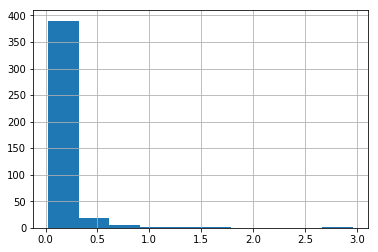

In [10]:
merged.groupby('City')['Volume Per Capita'].mean().hist()

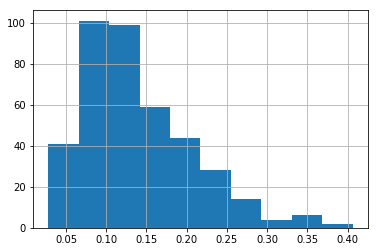

In [11]:
merged.groupby('City')['Volume Per Capita'].mean().sort_values(
    ascending = False)[20:].hist()

In [12]:
merged.groupby('City')[['Volume Per Capita', 'Population']].mean().sort_values(ascending = False
                                                                              ,by = 'Volume Per Capita')[:20]

,Volume Per Capita,Population
City,,
delaware,2.961115,159
bevington,1.685909,63
zwingle,1.425056,91
baldwin,0.996972,109
chester,0.917717,127
correctionville,0.845457,821
st. lucas,0.813424,143
wesley,0.762030,390
floyd,0.714152,335


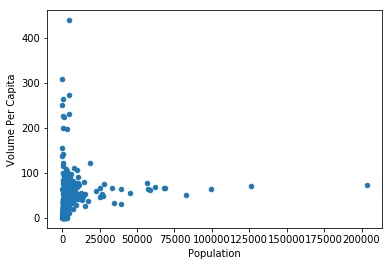

In [87]:
correct = merged.groupby('City')[['Volume Per Capita', 'Population']].agg({
    'Volume Per Capita': 'sum',
    'Population': 'mean'
})
correct.plot(x = 'Population',
                                                                       y= 'Volume Per Capita',
                                                                       kind = 'scatter')

In [94]:
merged[merged.City == "delaware"].Date

32043    01/25/2016
32044    04/18/2016
32045    08/17/2015
32046    10/05/2015
32047    11/02/2015
32048    12/14/2015
32049    01/09/2017
32050    01/22/2018
32051    03/19/2018
32052    04/10/2017
32053    04/23/2018
32054    05/21/2018
32055    05/22/2017
32056    06/13/2016
32057    07/03/2017
32058    07/09/2018
32059    08/01/2016
32060    09/10/2018
32061    09/11/2017
32062    10/03/2016
32063    11/07/2016
32064    11/20/2017
Name: Date, dtype: object

It appears that having a higher population is correlated with a lower volume per capita of alchohol

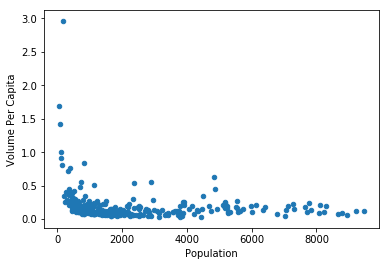

In [14]:
merged.groupby('City')[['Volume Per Capita', 'Population']].mean().sort_values(
ascending = False,
    by = 'Population'
)[40:].plot(x = 'Population',
                                                                       y= 'Volume Per Capita',
                                                                       kind = 'scatter')

In [48]:
# volByCity = merged.groupby('City')[['Volume Per Capita', 'Population']].mean().sort_values(ascending = False
#                                                                               ,by = 'Volume Per Capita')


#smallTowns
volByCity= merged.groupby('City')[['Volume Per Capita', 'Population']].mean().sort_values(
ascending = False,
    by = 'Population'
)[40:]

In [55]:
chunkSize = 200
volByCity['roundPop'] = volByCity.Population.map(lambda x: int(x / chunkSize) * chunkSize)

In [58]:
volByCityPop = volByCity.groupby('roundPop').mean()['Volume Per Capita']
xvals = list(range(0, max(volByCityPop.index) + chunkSize, chunkSize))
yvals = []
for x in xvals:
    try:
        yvals.append(volByCityPop[x])
    except:
        yvals.append(0)

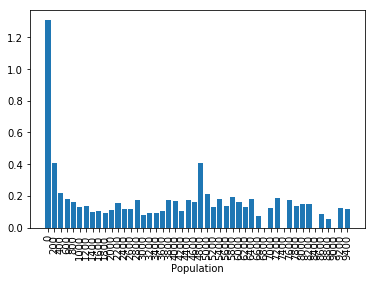

In [59]:
plt.bar([str(x) for x in xvals], yvals, orientation = 'vertical')
plt.xlabel('Population')
_ = plt.xticks(rotation = 90)

Looks like small towns drink a lot (probably because there's not much to do)

In [52]:
volByCity[volByCity['Population'] > 500].mean()

Volume Per Capita       0.145418
Population           2180.107558
roundPop             1984.883721
dtype: float64

In [53]:
volByCity[volByCity['Population'] < 500].mean()

Volume Per Capita      0.515995
Population           344.500000
roundPop             176.470588
dtype: float64

In [54]:
len(merged.City.unique())

418

In [15]:
one_hot_city = pd.get_dummies(merged.City)
merged = pd.merge(merged, one_hot_city, left_index=True, right_index=True)


merged.Date = pd.to_datetime(merged.Date, infer_datetime_format=True)
# The day of the week with Monday=0, Sunday=6
merged['Dayofweek'] = merged.Date.dt.dayofweek
# The week ordinal of the year
merged['Week'] = merged.Date.dt.weekofyear
merged['Month'] = merged.Date.dt.month

#print("merged.Date = {} and type = {}".format(merged.Date, type(merged.Date)))
us_holidays = holidays.UnitedStates()
merged['Holiday'] = merged.apply(lambda x: x['Date'] in us_holidays, axis =1)

In [38]:
merged.head()

,City,Date,aggVODKA,aggRUM,aggBRANDIES,aggSCHNAPPS,aggWHISKIES,aggTEQUILA,aggSCOTCH,aggOTHER,...,winfield,winterset,winthrop,woodbine,woodward,zwingle,Dayofweek,Week,Month,Holiday
0,ackley,2016-01-04,0.133333,0.066667,0.000000,0.000000,0.533333,0.000000,0.0,0.133333,...,0,0,0,0,0,0,0,1,1,False
1,ackley,2015-01-05,0.312500,0.250000,0.000000,0.062500,0.250000,0.000000,0.0,0.125000,...,0,0,0,0,0,0,0,2,1,False
2,ackley,2014-01-06,0.190476,0.047619,0.047619,0.047619,0.428571,0.047619,0.0,0.142857,...,0,0,0,0,0,0,0,2,1,False
3,ackley,2013-01-07,0.125000,0.000000,0.062500,0.000000,0.500000,0.000000,0.0,0.187500,...,0,0,0,0,0,0,0,2,1,False
4,ackley,2013-01-08,0.250000,0.250000,0.000000,0.000000,0.250000,0.125000,0.0,0.000000,...,0,0,0,0,0,0,1,2,1,False


In [39]:
list(merged)

['City',
 'Date',
 'aggVODKA',
 'aggRUM',
 'aggBRANDIES',
 'aggSCHNAPPS',
 'aggWHISKIES',
 'aggTEQUILA',
 'aggSCOTCH',
 'aggOTHER',
 'aggLIQUEURS',
 'numRecords',
 'Volume Sold (Liters)',
 'Bottles Sold',
 'Sale (Dollars)',
 'Population',
 'HousingUnits',
 'AreaSQMT',
 'DensitySQMP',
 'DensitySQMH',
 'Volume Per Capita',
 'Bottles Per Capita',
 'Sales Per Capita',
 'ackley',
 'adair',
 'adel',
 'afton',
 'akron',
 'albert city',
 'albia',
 'albion',
 'alburnett',
 'alden',
 'algona',
 'allison',
 'alta',
 'alta vista',
 'alton',
 'altoona',
 'alvord',
 'amana',
 'ames',
 'anamosa',
 'anita',
 'ankeny',
 'anthon',
 'arlington',
 'armstrong',
 'arnolds park',
 'atkins',
 'atlantic',
 'audubon',
 'aurelia',
 'avoca',
 'baldwin',
 'bancroft',
 'baxter',
 'bedford',
 'belle plaine',
 'bellevue',
 'belmond',
 'bettendorf',
 'bevington',
 'blairstown',
 'bloomfield',
 'blue grass',
 'bondurant',
 'boone',
 'britt',
 'brooklyn',
 'buffalo',
 'buffalo center',
 'burlington',
 'bussey',
 'camanc

In [ ]:
merged.to_csv("/content/gdrive/My Drive/College/DATA 401/Iowa-Liquor-Sales/GrossSalesAggregated_Final.csv", index=False)